Lexicon Method with VADER, AFINN and Textblob technique (Sentiment Analysis)

In [ ]:
# import pandas as pd

# # load the dataset
# df = pd.read_csv('Cleaned_News_Articles_Final2.csv')

In [ ]:
# df = df[['headline']]

VADER

In [ ]:
# import pandas as pd
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# # # VADER sentiment analyzer
# # analyzer = SentimentIntensityAnalyzer()

# # # classify sentiment
# # def classify_sentiment(text):
# #     # sentiment scores
# #     scores = analyzer.polarity_scores(text)
# #     # compound score
# #     compound = scores['compound']
# #     # sentiment based on the compound score
# #     if compound >= 0.05:
# #         return 'positive'
# #     elif compound <= -0.05:
# #         return 'negative'
# #     else:
# #         return 'neutral'

# # WIthout NEUTRAl

# # classify sentiment without NEUTRAL
# def classify_sentiment(text):
#     # sentiment scores
#     scores = analyzer.polarity_scores(text)
#     # compound score
#     compound = scores['compound']
#     # sentiment based on the compound score
#     if compound >= 0:
#         return 'positive'
#     else:
#         return 'negative'

# df['sentiment'] = df['headline'].apply(classify_sentiment)
# print(df.head(10))


AFINN

In [ ]:
# import pandas as pd
# from afinn import Afinn

# # afinn sentiment analyzer
# afinn = Afinn()

# # # classify sentiment
# # def classify_sentiment(text):
# #     # sentiment score
# #     score = afinn.score(text)
# #     # sentiment based on the score
# #     if score > 0:
# #         return 'positive'
# #     elif score < 0:
# #         return 'negative'
# #     else:
# #         return 'neutral'

# # WIthout NEUTRAl

# # classify sentiment
# def classify_sentiment(text):
#     # sentiment score
#     score = afinn.score(text)
#     # sentiment based on the score
#     if score > 0:
#         return 'positive'
#     else:
#         return 'negative'

# df['sentiment'] = df['headline'].apply(classify_sentiment)
# print(df.head(10))


Textblob

In [ ]:
# import pandas as pd
# from textblob import TextBlob

# # # classify sentiment
# # def classify_sentiment(text):
# #     analysis = TextBlob(text)
# #     polarity = analysis.sentiment.polarity
    
# #     if polarity > 0:
# #         return 'positive'
# #     elif polarity < 0:
# #         return 'negative'
# #     else:
# #         return 'neutral'

# # WIthout NEUTRAl

# # classify sentiment
# def classify_sentiment(text):
#     analysis = TextBlob(text)
#     polarity = analysis.sentiment.polarity
    
#     if polarity > 0:
#         return 'positive'
#     else:
#         return 'negative'

# df['sentiment'] = df['headline'].apply(classify_sentiment)
# print(df.head(10))


In [ ]:
# print(df['sentiment'].value_counts())

In [ ]:
# df.to_csv("textblob_without_neutral.csv", index=False)

Train the Classifier with ML models (LR, SVM, MNB, RF, KNN)

Load dataset

In [1]:
import pandas as pd

# load the dataset
dataset_path = 'kmeans_with_augmented_subset.csv'    #can CHANGE
df = pd.read_csv(dataset_path)

Split dataset

In [2]:
from sklearn.model_selection import train_test_split

# split into training and testing sets (70 30)
X_train, X_test, y_train, y_test = train_test_split(df['headline'], df['sentiment'], test_size=0.3, random_state=42)

Encode labels

In [3]:
# # encode labels (negative=0 positive=1 neutral=2)
y_train = y_train.map({'negative': 0, 'positive': 1, 'neutral': 2})
y_test = y_test.map({'negative': 0, 'positive': 1, 'neutral': 2})

# encode labels without NEUTRAL
# y_train = y_train.map({'negative': 0, 'positive': 1})
# y_test = y_test.map({'negative': 0, 'positive': 1})

Feature Extraction

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF vector
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

Train ML models

In [5]:
from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.svm import SVC
# from sklearn.neighbors import KNeighborsClassifier



# ML baseline model (select 1 to run)    #can CHANGE
ml_models = LogisticRegression()
# ml_models = RandomForestClassifier()
# ml_models = MultinomialNB()
# ml_models = SVC()
# ml_models = KNeighborsClassifier()


ml_models.fit(X_train_tfidf, y_train)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


LogisticRegression()

MLflow Server

In [ ]:
import mlflow
from mlflow.tracking import MlflowClient

# convert model name to string
model_name = ml_models.__class__.__name__

# start MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("sentiment-analysis-lexicon")

# initialize MLflow client
client = MlflowClient()

# experiment ID
experiment_id = client.get_experiment_by_name("sentiment-analysis-lexicon").experiment_id

runs = client.search_runs(experiment_ids=[experiment_id])

# initial version to 0
max_version = 0

# find the max version for the current version model
for run in runs:
    run_name = run.data.tags.get('mlflow.runName')
    if run_name and run_name.startswith(model_name):        
        # extract version number from the run name
        try:
            version = int(run_name.split('_v')[-1])
        except ValueError:
            continue  # skip if version is not an integer

        # update max_version if this version is greater
        max_version = max(max_version, version)

# increase the version by adding 1
new_version = max_version + 1

# new run name
new_run_name = f"{model_name}_v{new_version}"
mlflow.start_run(run_name=new_run_name)

mlflow.log_param("model name", model_name)
mlflow.log_param("dataset_name", dataset_path)
mlflow.log_param("data size", df.shape)

Predict accuracy (Based model)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# predict test 
y_pred = ml_models.predict(X_test_tfidf)

print("Based Model:")

#  training accuracy
trainAccuracy = ml_models.score(X_train_tfidf, y_train)
print("Training Accuracy:", trainAccuracy)

# training loss (MISC)
training_loss = ml_models.score(X_train_tfidf, y_train)
print("Training Loss (MISC):", 1 - training_loss)

# test accuracy
testAccuracy = accuracy_score(y_test, y_pred)
print("Testing Accuracy:", testAccuracy)

# precison recall f1score
print(classification_report(y_test, y_pred))

Confusion matrix (Based model)

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# # decode the labels back to original
# reverse_mapping = {0: 'negative', 1: 'positive', 2: 'neutral'}
# decoded_y_pred = [reverse_mapping[label] for label in y_pred]
# decoded_y_test = [reverse_mapping[label] for label in y_test]

# # create confusion matrix
# conf_matrix = confusion_matrix(decoded_y_test, decoded_y_pred)

# # plot confusion matrix 
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.xticks(ticks=[0.5, 1.5, 2.5], labels=['negative', 'positive', 'neutral'])
# plt.yticks(ticks=[0.5, 1.5, 2.5], labels=['negative', 'positive', 'neutral'])
# plt.show()

# Without NEUTRAL

# decode the labels back to original
reverse_mapping = {0: 'negative', 1: 'positive'}
decoded_y_pred = [reverse_mapping[label] for label in y_pred]
decoded_y_test = [reverse_mapping[label] for label in y_test]

# create confusion matrix
conf_matrix = confusion_matrix(decoded_y_test, decoded_y_pred)

# plot confusion matrix 
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5], labels=['negative', 'positive'])
plt.yticks(ticks=[0.5, 1.5], labels=['negative', 'positive'])
plt.show()

ROC curve (Based model)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

# # binarize the labels
# y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

# # proba for proba models , decision for svm
# y_pred_scores = ml_models.predict_proba(X_test_tfidf)       #can CHANGE
# # y_pred_scores = ml_models.decision_function(X_test_tfidf)   

# # compute and plot ROC curve
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# n_classes = y_test_binarized.shape[1]

# for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_scores[:, i])
#     roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_pred_scores[:, i])

# plt.figure()

# colors = ['blue', 'red', 'green']
# classes = ['negative', 'positive', 'neutral']
# for i, color in enumerate(colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=2, 
#              label=f'ROC curve for {classes[i]} (area = {roc_auc[i]:0.2f})')

# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-class')
# plt.legend(loc="lower right")
# plt.show()

# Without Neutral

# ROC curve 
y_pred_scores = ml_models.predict_proba(X_test_tfidf)[:, 1]    #can CHANGE
# y_pred_scores = ml_models.decision_function(X_test_tfidf)   

fpr, tpr, _ = roc_curve(y_test, y_pred_scores)
auc_score = roc_auc_score(y_test, y_pred_scores)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Grid search for Fine-tuning models (Hypertuning)

In [6]:
from sklearn.model_selection import GridSearchCV

# ML models classifier                 #can CHANGE
ml_models = LogisticRegression()  
# ml_models = RandomForestClassifier()
# ml_models = MultinomialNB()
# ml_models = SVC()
# ml_models = KNeighborsClassifier()


# hyperparameters to tune    #can CHANGE

#LR
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# #RF
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_features': ['auto', 'sqrt'],
#     'max_depth': [10, 20],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2],
#     'bootstrap': [True]
# }

# #MNB
# param_grid = {
#     'alpha': [0.1, 0.5, 1.0],
#     'fit_prior': [True, False]
# }

# #SVM
# param_grid = {
#     'C': [1, 5],
#     'kernel': ['linear', 'poly'],
#     'gamma': ['scale', 'auto']
# }

# # KNN
# param_grid = {
#     'n_neighbors': [3, 5, 7],
#     'weights': ['uniform', 'distance'],
#     'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
# }


# perform grid search with cross-validation
grid_search = GridSearchCV(estimator=ml_models, param_grid=param_grid, cv=5, scoring='accuracy')

# fit the grid search to the data
grid_search.fit(X_train_tfidf, y_train)

# best hyperparameters and corresponding score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Cross-Validation Accuracy:", best_score)

# make predictions
best_model = grid_search.best_estimator_
predictions_test = best_model.predict(X_test_tfidf)

# calculate accuracy 
best_model_train_score = best_model.score(X_train_tfidf, y_train)
best_model_test_score = best_model.score(X_test_tfidf, y_test)

print()
print("Best Model:")
print("Training Score: {}\nTest Score: {}".format(best_model_train_score, best_model_test_score))

# classification report
report = classification_report(y_test, predictions_test, output_dict=True)

print("\nClassification Report:")
print(classification_report(y_test, predictions_test))

# mlflow.log_param("best params", best_params)

# mlflow.log_metric("train accuracy", best_model_train_score)
# mlflow.log_metric("test accuracy", best_model_test_score)

# mlflow.log_metric("Precision", report['weighted avg']['precision'])
# mlflow.log_metric("Recall", report['weighted avg']['recall'])
# mlflow.log_metric("F1 Score", report['weighted avg']['f1-score'])

c:\Users\ChokJoe\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\ChokJoe\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\ChokJoe\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\ChokJoe\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\ChokJoe\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\ChokJoe\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: T

Best Hyperparameters: {'C': 10.0, 'penalty': 'l2', 'solver': 'saga'}
Best Cross-Validation Accuracy: 0.946904761904762

Best Model:
Training Score: 0.9994761904761905
Test Score: 0.9467777777777778


NameError: name 'classification_report' is not defined

Confusion matrix (Best model)

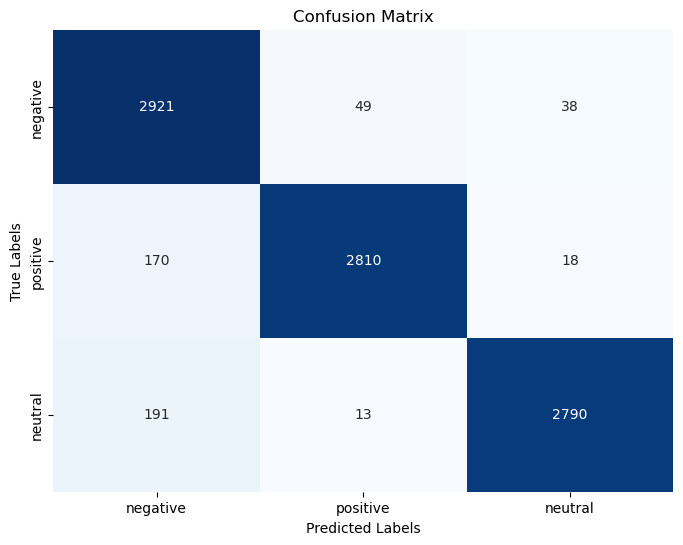

In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# decode the labels back to original
reverse_mapping = {0: 'negative', 1: 'positive', 2: 'neutral'}
decoded_y_pred = [reverse_mapping[label] for label in predictions_test]
decoded_y_test = [reverse_mapping[label] for label in y_test]

# create confusion matrix
conf_matrix = confusion_matrix(decoded_y_test, decoded_y_pred)

# plot confusion matrix 
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5, 2.5], labels=['negative', 'positive', 'neutral'])
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=['negative', 'positive', 'neutral'])
plt.show()

# # Without NEUTRAL

# # decode the labels back to original
# reverse_mapping = {0: 'negative', 1: 'positive'}
# decoded_y_pred = [reverse_mapping[label] for label in predictions_test]
# decoded_y_test = [reverse_mapping[label] for label in y_test]

# # create confusion matrix
# conf_matrix = confusion_matrix(decoded_y_test, decoded_y_pred)

# # plot confusion matrix 
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.xticks(ticks=[0.5, 1.5], labels=['negative', 'positive'])
# plt.yticks(ticks=[0.5, 1.5], labels=['negative', 'positive'])
# plt.show()

ROC curve (Best model)

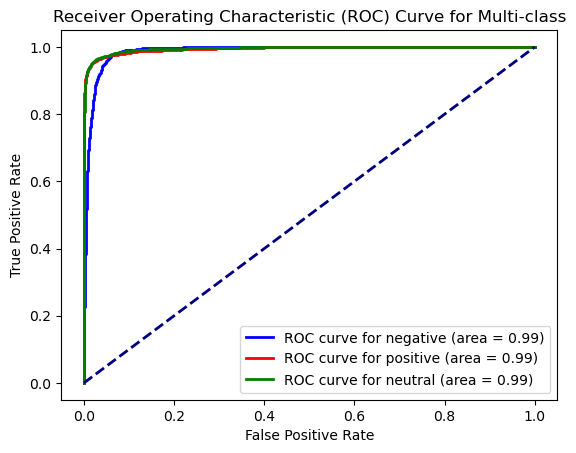

In [9]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

# binarize the labels
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])


# proba for proba models , decision for svm
y_pred_scores = best_model.predict_proba(X_test_tfidf)        #can CHANGE
# y_pred_scores = best_model.decision_function(X_test_tfidf)

# compute and plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_scores[:, i])
    roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_pred_scores[:, i])

plt.figure()

colors = ['blue', 'red', 'green']
classes = ['negative', 'positive', 'neutral']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, 
             label=f'ROC curve for {classes[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-class')
plt.legend(loc="lower right")
plt.show()


# # Without Neutral

# # ROC curve 
# y_pred_scores = best_model.predict_proba(X_test_tfidf)[:, 1]   #can CHANGE
# # y_pred_scores = best_model.decision_function(X_test_tfidf)   

# fpr, tpr, _ = roc_curve(y_test, y_pred_scores)
# auc_score = roc_auc_score(y_test, y_pred_scores)

# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
# plt.show()

Save best model and feature extraction

In [10]:
# import os
# import joblib

# # create subfolders
# base_folder = '5 Unsupervised Sentiment Analysis/lexicon_models_fextract'
# models_folder = os.path.join(base_folder, 'models')
# feature_extract_folder = os.path.join(base_folder, 'feature_extract')

# # double confirm 
# os.makedirs(models_folder, exist_ok=True)
# os.makedirs(feature_extract_folder, exist_ok=True)

# # save best model and TFIDF vectorizer 
# joblib.dump(best_model, os.path.join(models_folder, 'best_knn_model_textblob_without_neutral.pkl'))    #CHANGE model name and dataset name
# print('Best model saved')

# joblib.dump(tfidf_vectorizer, os.path.join(feature_extract_folder, 'knn_tfidf_textblob_without_neutral.pkl'))    #CHANGE also
# print('TFIDF saved')

import os
import joblib

# create subfolders
base_folder = '5 Unsupervised Sentiment Analysis/lexicon_models_fextract'
models_folder = os.path.join(base_folder, 'models')
feature_extract_folder = os.path.join(base_folder, 'feature_extract')

# double confirm 
os.makedirs(models_folder, exist_ok=True)
os.makedirs(feature_extract_folder, exist_ok=True)

# save best model and TFIDF vectorizer 
joblib.dump(best_model, os.path.join(models_folder, 'kmean.pkl'))    #CHANGE model name and dataset name
print('Best model saved')

joblib.dump(tfidf_vectorizer, os.path.join(feature_extract_folder, 'kmean.pkl'))    #CHANGE also
print('TFIDF saved')

Best model saved
TFIDF saved


Random Test Unseen data

In [21]:
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer

# load the saved model and tfidf vectorizer
model_filename = '5 Unsupervised Sentiment Analysis/lexicon_models_fextract/models/kmean.pkl'
vectorizer_filename = '5 Unsupervised Sentiment Analysis/lexicon_models_fextract/feature_extract/kmean.pkl'

model = joblib.load(model_filename)
vectorizer = joblib.load(vectorizer_filename)

# encode the label
label_encoding = {0: 'negative', 1: 'positive', 2: 'neutral'}
# label_encoding = {0: 'negative', 1: 'positive'}


# unseen data
# input_text = "McDonald’s shortens breakfast time in Australia as bird flu causes egg shortage"
# input_text = "Tesla sales fall again as more automakers crowd electric vehicle market"
input_text = "today is a bad day"


# vector the unseen data
transformed_input = vectorizer.transform([input_text])

# predit the unseen data by usig saved model
prediction = model.predict(transformed_input)

# decode the label into its original class
decoded_prediction = label_encoding[prediction[0]]

# print result
print(f"Prediction: {decoded_prediction}")

Prediction: negative
